In [18]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2      
from IPython.display import Image, display, clear_output

import itertools
from operator import itemgetter
# opencv, numpy
import cv2
import numpy as np
np.set_printoptions(precision=2)

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
matplotlib.rcParams['figure.figsize'] = (19, 10)

# bundle adjustment
import pysba as ba

# project files
import utils as utils
from common_misc import homogeneous2euclidean, euclidean2homogeneous, projective2img, img2projective, plot_camera, draw_points
import maths as mth
import image_matches as mt
import fundamental as fd
import track as tk
import vps as vp
import reconstruction as rc

with_intrinsics = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Conventions on notation 
In the code provided we try to differentiate between variables holding homogeneous and euclidean coordinates. Any variable $x$ holding homogeneous coordinates will be denoted as $x_h$ and its code correspondant as `x_h`. Accordingly the euclidean coordinates will be denoted as $x_e$, `x_e`.

# Structure from Motion 
In this final laboratory, the main goal is to design a complete Structure from Motion
(SfM) pipeline in order to achieve a 3D reconstruction of the given uncalibrated images.
The real data that we are using are 5 facade images, the ones that have been used in
the previous labs. You can use [more images](https://docs.opencv.org/3.4/d7/dd5/group__datasets__msm.html) or another sequence of images if you like: 

* All datasets, with ground-truth, and cameras: [home](https://icwww.epfl.ch/multiview/denseMVS.html)
* Castle dataset: [castle](https://icwww.epfl.ch/multiview/castle_dense_large.html)


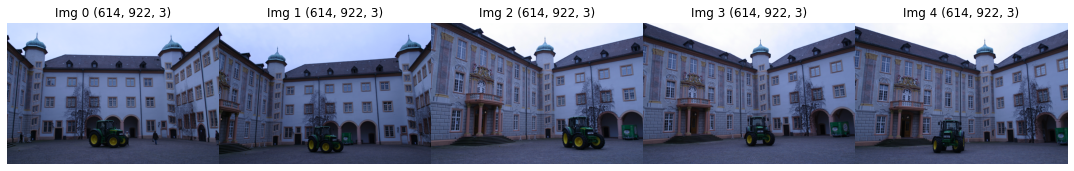

In [3]:
n_imgs = 5
rgb_imgs, gray_imgs = utils.load_n_images(n_imgs)
fig = utils.plot_images(rgb_imgs)

The processing of the images is computationally demanding, so perhaps at start its best to load only a couple of the images

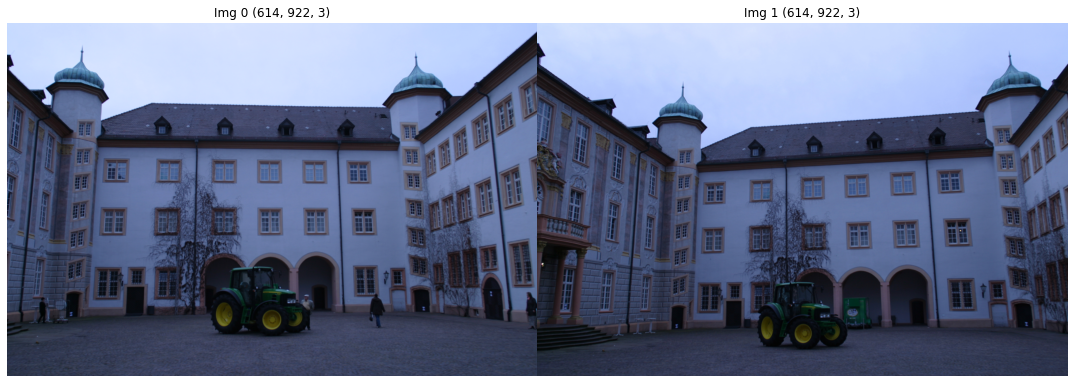

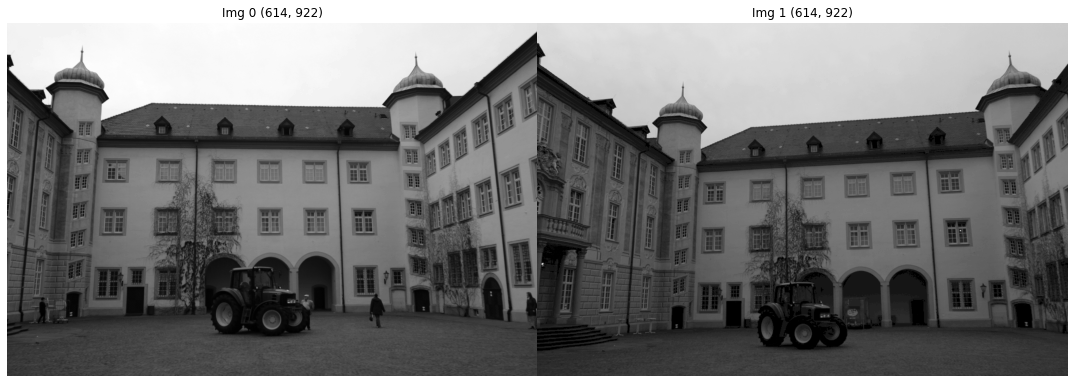

In [3]:
n_imgs = 2
rgb_imgs, gray_imgs = utils.load_n_images(n_imgs)

fig = utils.plot_images(rgb_imgs)
fig2 = utils.plot_images(gray_imgs, cmap='gray')

The function `process_images` takes the list of loaded images and generates all the required features and data for the assignment. You are encouraged to understand how the pipeline is working and to modify it. See its documentation for details on the return types.

If you perform changes the feature extraction and matching pipeline, make sure to verify the quality of the results. That is, if your Fundamental Matrix estimates are bad, you can probably spot them by eye before proceeding.

In [4]:
orb_features = [None] * n_imgs      # list of features per image
tracks = []                         # list of tracking views 
hs_vs = {}                          # dictionary as hash table of views-tracks
vanish_pts = [None] * n_imgs        # list of vanishing points per image 
cams_pr = [None] * n_imgs           # list of projective cameras per image 
cams_aff = [None] * n_imgs          # list of affine cameras per image 
cams_euc = [None] * n_imgs          # list of euclidean cameras per image 
Xprj = {}              # Dict of projective 3d points per image pairs 
Xaff = {}              # Dict of affine 3d points per image pairs
Xeuc = {}              # Dict of euclidean 3d points per image pairs

img_pairs_features, orb_features, vanish_pts, tracks, hs_vs = utils.process_images(rgb_imgs, gray_imgs)
clear_output()

Showing data from Cam0 and Cam1
- Fundamental Matrix F:
 [[-3.57e-05  3.12e-04 -1.34e-04]
 [-4.25e-04 -2.17e-05  5.98e-01]
 [ 9.88e-02 -5.64e-01 -4.79e+01]]
- Vanish Point Camera 0:
 [[10555.75   533.3 ]
 [  768.45  2762.12]
 [  424.1  -3808.61]]


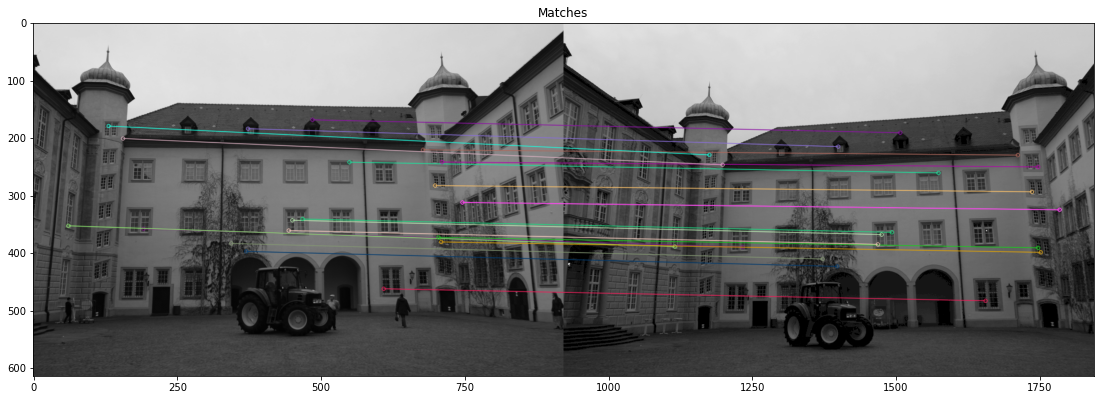

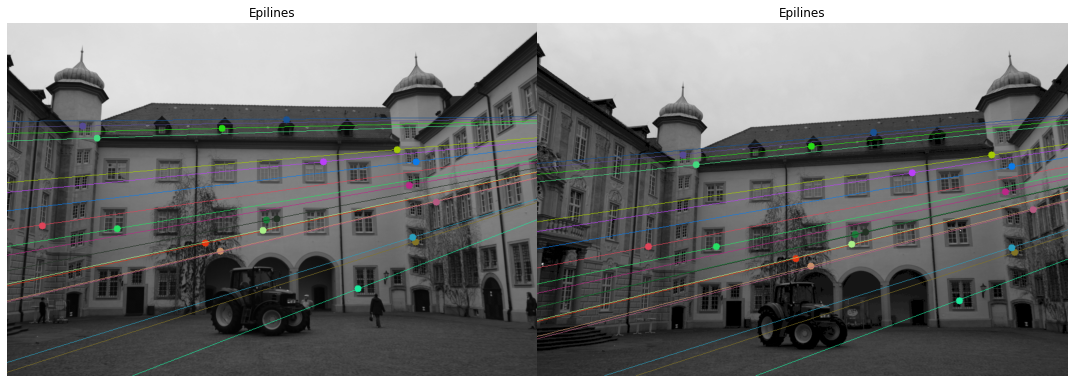

In [5]:
for (img1_id, img2_id) in img_pairs_features.keys():
    print(f"Showing data from Cam{img1_id} and Cam{img2_id}")
    img12_feat = img_pairs_features[(img1_id, img2_id)]
    F = img12_feat.F                          # Estimated fundamental matrix F
    matches = img12_feat.matches              # All matches between images 
    inliers_idx = img12_feat.inliers_idx      # All F inlier indices of matches 
    x1_e = img12_feat.x1_e
    x2_e = img12_feat.x2_e
    xr1_e = img12_feat.xr1_e
    xr2_e = img12_feat.xr2_e
    x1_h = img12_feat.x1_h
    x2_h = img12_feat.x2_h
    # Choose some inliers for clearer visualization 
    selected_inliers = np.random.choice(inliers_idx, 20)

    print(f"- Fundamental Matrix F:\n", F)
    print(f"- Vanish Point Camera {img1_id}:\n {vanish_pts[img1_id]}")
    img_ij = cv2.drawMatches(gray_imgs[img1_id], orb_features[img1_id][0],
                             gray_imgs[img2_id], orb_features[img2_id][0],
                             itemgetter(*selected_inliers)(matches),
                             None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.title("Matches")
    plt.imshow(img_ij)
    
    imgs = utils.display_epilines(gray_imgs[img1_id], gray_imgs[img2_id], 
                                  x1_e.T[selected_inliers], 
                                  x2_e.T[selected_inliers], F)

    fig = utils.plot_images(imgs, titles=["Epilines"]*2)

Showing data from Cam0 and Cam1
- Fundamental Matrix F:
 [[-3.57e-05  3.12e-04 -1.34e-04]
 [-4.25e-04 -2.17e-05  5.98e-01]
 [ 9.88e-02 -5.64e-01 -4.79e+01]]
- Vanish Point Camera 0:
 [[10555.75   533.3 ]
 [  768.45  2762.12]
 [  424.1  -3808.61]]


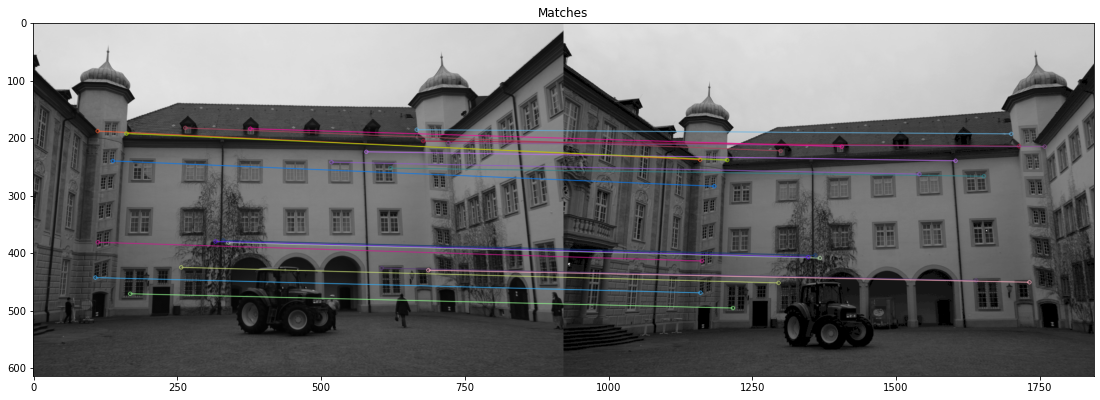

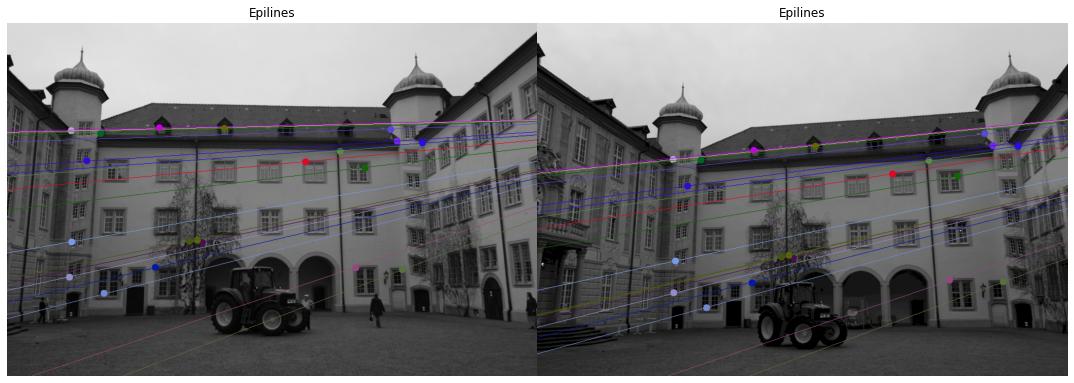

In [39]:
print(f"Showing data from Cam{0} and Cam{1}")
img12_feat = img_pairs_features[(0, 1)]
F = img12_feat.F                          # Estimated fundamental matrix F
matches = img12_feat.matches              # All matches between images 
inliers_idx = img12_feat.inliers_idx      # All F inlier indices of matches 
x1_e = img12_feat.x1_e
x2_e = img12_feat.x2_e
xr1_e = img12_feat.xr1_e
xr2_e = img12_feat.xr2_e
x1_h = img12_feat.x1_h
x2_h = img12_feat.x2_h
# Choose some inliers for clearer visualization 
selected_inliers = np.random.choice(inliers_idx, 20)

print(f"- Fundamental Matrix F:\n", F)
print(f"- Vanish Point Camera {0}:\n {vanish_pts[0]}")
img_ij = cv2.drawMatches(gray_imgs[0], orb_features[0][0],
                            gray_imgs[1], orb_features[1][0],
                            itemgetter(*selected_inliers)(matches),
                            None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.title("Matches")
plt.imshow(img_ij)

imgs = utils.display_epilines(gray_imgs[0], gray_imgs[1], 
                                x1_e.T[selected_inliers], 
                                x2_e.T[selected_inliers], F)

fig = utils.plot_images(imgs, titles=["Epilines"]*2)

# 1. Computation of Projective cameras (n=2)

Compute the estimated Projective Camera Matrices for each of the Cameras in the images.
See Result 9.15 of MVG

C:\Users\galve\AppData\Local\Temp\ipykernel_16012\347103822.py:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  S = np.asarray([[0., -epipole[2], 0.],


[[-9.99e-01 -9.99e-01 -9.99e-01  9.99e-01]
 [-1.43e-01  5.19e-01  4.78e+01  4.45e-02]
 [-9.75e-04 -5.88e-04  5.96e-01  5.52e-04]]
Camera center [0. 0. 0.]
Camera center [-6.59e-04 -7.80e-01 -4.54e-01]


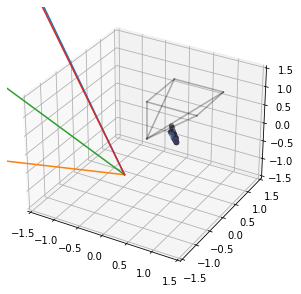

In [48]:
cams_pr = [None]*n_imgs

def estimate_proj_camera(F, epipole, v, lambd=1):
    """
        Function to estimate a second Projection matrix assuming a first Projection matrix = [I|0]
        :param F: Fundamental matrix
        :param epipole: epipole point from the second image
        :param v: 3-vector
        :param lambd: scale factor (non zero value)
        :return:
            - Projection matrix of the form: [[epipole_x]F + epipole*v.T | lambd*e] 
    """
    assert lambd != 0

    S = np.asarray([[0., -epipole[2], 0.],
                          [epipole[2], 0., -epipole[0]],
                          [-epipole[1], epipole[0], 0.]], dtype='float64')
    # S = mth.hat_operator(epipole)
    
    add_factor = epipole @ v

    P = np.concatenate(((S@F + add_factor), lambd*epipole), axis=1)
    return P
    

def plot_cameras_and_points(X, P1, P2, rgb_img, x1, w=1, h=1, s=1, ax=None):
    """
    You are encouraged to debug your program graphically
    """
    # Render the 3D point cloud
    x_img = np.transpose(x1[:2]).astype(int)
    rgb_txt = (rgb_img[x_img[:,1], x_img[:,0]])/255
    draw_points(X.T, color=rgb_txt, ax=ax)

    low_lim, up_lim = -1.5, 1.5
    plot_camera(P1,1,1, s, ax=ax, alpha=0.3, color="k")
    plot_camera(P2,w,h, s, ax=ax)
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    
    
# Asume the Camera 0 of image 0 has a cannonical matrix P 
P0 = np.float32(np.c_[np.eye(3), np.zeros(3)])
cams_pr[0] = P0

#Compute the epipole considering equation F.T @ e' = 0
epipole_2 = mth.nullspace(F.T)
# epipole_2 = epipole_2 / epipole_2[2]

for cam_id in range(1, len(rgb_imgs)):
    cams_pr[cam_id] = estimate_proj_camera(F, epipole_2, -np.array([[1,1,1]]), 1)
    print(cams_pr[cam_id])

X_pred = rc.triangulate(x1_h[:,selected_inliers], x2_h[:,selected_inliers], cams_pr[0], cams_pr[1], rgb_imgs[0].shape[:2])
X_eucl = homogeneous2euclidean(X_pred)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')

h, w = rgb_imgs[0].shape[:2]
plot_cameras_and_points(X_eucl,P0,cams_pr[1],rgb_imgs[0],x1_e[:,selected_inliers], ax=ax, h=h, w=w)

In [44]:
np.shape(vanish_pts)

(2, 3, 2)

### 1.2 Estimate the reprojection error 

In [58]:
projective_error = [None] * len(cams_pr)


def compute_reproj_error(X, P1, P2, xr1, xr2):
    """
    - x1: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 1 reference frame 
    - x2: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 2 reference frame.
    - P1: Camera 1 matrix
    - P2: Camera 2 matrix 
    - X: (4, `n_points`) homogenous coordinates of points in 3D space
    Compute the reprojection error from `X` to each of the camera's projective coordinates
    @return: error
    """

    x1_pred = P1 @ X
    x1_pred_e = x1_pred[2:, :] / x1_pred[2, :] 
    x2_pred = P2 @ X
    x2_pred_e = x2_pred[2:, :] / x2_pred[2, :] 

    cam1_errors = np.sqrt(np.sum((xr1-x1_pred_e)**2))
    cam2_errors = np.sqrt(np.sum((xr2-x2_pred_e)**2))

    return cam1_errors+cam2_errors


for cam_id in range(1, len(cams_pr)):
    img12_feat = img_pairs_features[(0, cam_id)]
    x1_e, x2_e = img12_feat.x1_e, img12_feat.x2_e
    xr1_e, xr2_e = img12_feat.xr1_e, img12_feat.xr2_e

    # Projective triangulation for 3D structure.
    Xp = rc.estimate_3d_points_2(cams_pr[cam_id-1], cams_pr[cam_id], xr1_e, xr2_e)
    Xprj[(0, cam_id)] = Xp
    # Add estimated 3d projective points to tracks
    tk.add_pts_tracks(Xp, x1_e, x2_e, cam_id-1, cam_id, tracks, hs_vs)
        
    # Compute reprojection error.
    error = compute_reproj_error(Xp, cams_pr[cam_id-1], cams_pr[cam_id], xr1_e, xr2_e)
    # projective_error[cam_id] = error
    print(f'Error on cam{cam_id}: {error}')
    
    # Display points on each image 
    x_img = np.transpose(x1_e).astype(int)
    rgb_txt = (rgb_imgs[cam_id][x_img[:,1], x_img[:,0]])/255
    draw_points(Xp.T[:,:3], color=rgb_txt, ax=ax)
    # utils.display_3d_points(Xp.T[:, :3], x1_e, rgb_imgs[cam_id])

Error on cam1: 42531.442694338155


## 1.3 Affine Rectification
Perform an affine rectification, using an estimated Homography $H_{a\leftarrow p}$. Then, transform the projected 3D points and Projective Camera Matrices to Affine. 

Compute the reprojection error of the affine projected points, and compare with previous error.

In [47]:
def estimate_aff_homography(P1, P2, vp1, vp2):
    # Define affine rectification homography
    vp_3d = rc.estimate_3d_points_2(P1, P2, vp1.T, vp2.T)

    plane_infinity = mth.nullspace(vp_3d.T)
    plane_infinity = plane_infinity / plane_infinity[3]

    aff_hom = np.eye(4,4)
    aff_hom[-1,:] = plane_infinity[:,0]
    return aff_hom


Haps = [None]*n_imgs
cams_aff = [None]*n_imgs
affine_error = [None]*n_imgs


for cam_id in range(1, len(cams_pr)):
    vanish_pt1 = vanish_pts[cam_id-1]
    vanish_pt2 = vanish_pts[cam_id]
    P1 = cams_pr[cam_id-1]
    P2 = cams_pr[cam_id]
    # Homography projective->affine 
    Hap = estimate_aff_homography(P1, P2, vanish_pt1, vanish_pt2)   
    Haps[cam_id] = Hap
    
    Xproj = Xprj[(0, cam_id)]
    # Transform 3D points and cameras to affine space
    Xaff, P_aff = rc.transform(Hap, Xproj, cams_pr)
    
    # Add estimated 3d affine points to tracks (reuse your code)
    tk.add_pts_tracks(Xaff, x1_e, x2_e, cam_id-1, cam_id, tracks, hs_vs)
    print('Affine 3D points added to tracks')
    
    # Estimate the reprojection error 
    error = compute_reproj_error(Xaff, cams_pr[cam_id-1], cams_pr[cam_id], xr1_e, xr2_e)
    affine_error[cam_id] = error
    

KeyError: Ellipsis

## 1.4 Metric Verification

The next step is to perform metric rectification by applying a similarity transform to the affine results. 

First compute the transforming homography from vanishing points and the camera constrains skew = 0, squared pixels. Then perform the transformation to Euclidean space and compare reprojection errors.

In [ ]:
def estimate_euc_homography(P1, P2, vp1, vp2):
    # ________________________
    # Your code here
    # ________________________
    return None


Heas = [None]*n_imgs
cams_euc = [None]*n_imgs
euclidean_error = [None]*n_imgs

for cam_id in range(1, len(cams_pr)):    
    
    if cam_id == 1 and with_intrinsics:
        P1, P2 = rc.compute_eucl_cam(F, x1_e, x2_e)
        Xeuc = rc.estimate_3d_points_2(P1, P2, xr1_e, xr2_e)
    else: # compare results with the results from intrinsic camera
        Hea = estimate_euc_hom(cams_aff[i], vanish_pts[i])
        Xeuc, cams_euc = rc.transform(Hea, Xaff, cams_aff)
    
    #  Add estimated 3d euclidean points to tracks (reuse your code)
    tk.add_pts_tracks(Xeuc, x1_e, x2_e, cam_id-1, cam_id, tracks, hs_vs)
    
    error = rc.compute_reproj_error(Xeuc, cams_euc[cam_id-1], cams_euc[cam_id], xr1_e, xr2_e)
    euclidean_error[cam_id] = error

# Bundle Adjustment 
We have now gathered the data to refine our estimates using non-linear optimization. We will use a Simple Bundle Adjustment algorithm defined in the file `pysba.PySBA` (see [here](http://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html)). You have to:

1. Understand the parameters of this function and write the function `adapt_format_pysba` which will handle a translation from the data we collected to the format required by the algorithm.
2. Understand and explain how the optimization problem is formulated.
3. Modify the class code to plot the Jacobian Sparse matrix in an image. You should understand and explain the role of this matrix, and the causes for its sparsity (what are each dimensions/rows/columns accounting for?). Hint you can use the `plt.spy(A)` function to see the sparcity patter. 
4. Assert the effect of bundle adjustment, both quantitatively and qualitatively speaking. Be clear on which could be the sources of uncertainty/error/outliers. 


In [ ]:
def adapt_format_pysba(tracks, cams):
    
    # 1. Separate intrinsic from extrinsic parameters of your camera matrices. 
    # How can you do it? Justify your assumptions and methodology.  
    
    # 2. Convert tracks into 3D, 2D points and their respective Observations masks.

    return camera_params, points_3d, points_2d, camera_indices, points_2d_indices


# Adapt cameras and 3D points to PySBA format
cams_ba, X_ba, x_ba, cam_idxs, x_idxs = adapt_format_pysba(tracks, cams_euc)

badj = ba.PySBA(cams_ba, X_ba, x_ba, cam_idxs, x_idxs)
cams_ba, Xba = badj.bundleAdjust()


# Update 3D points and tracks with optimised cameras and points use them for visualization.
tk.update_ba_pts_tracks(Xba, x1_e, x2_e, cam_id-1, cam_id, tracks, hs_vs)

# Optional tasks
- Estimate affine homography from the 3 vanishing points and F (Alg. 13.1 p332, result 10.3 p271)
- Perform Bundle Adjustment over the estimation of the vanishing points and all available images, with PySBA

For more than 2 images: 
- Investigate strategies to improve the pipeline:
   -in results: number of points, reprojection error, camera poses
   -in implementation: time of computation, resources, etc.
   Reference papers for improvement strategies: 
       -J. L. Schönberger and J. Frahm, "Structure-from-Motion Revisited," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 4104-4113.
- Implement the  resection method, as explained in MVG, Alg 7.1
- Implement track management for more than 2 images, with tracks structure

In [25]:
def resection(tracks, cam_id):
    # extract 3D-2D correspondences from tracks
    Xi = np.asarray([t.pt for t in tracks if cam_id in t.views and t.pt[3] != 0])
    xi = np.asarray([t.views[cam_id] for t in tracks if cam_id in t.views and t.pt[3] != 0])
    
    # ________________________
    # Your code here
    # ________________________
    
    return P